In [1]:
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import ccxt
import time
from math import isclose
import Metriche_di_performance as mdp
from datetime import datetime
import numpy as np
import seaborn as sns
from sklearn.model_selection import ParameterGrid

# Function

In [2]:
def calcola_rendimento_portafoglio_ideale_multicrypto(lista_colonne_prezzi, capitale_iniziale, lista_token_iniziali, min_acquisto=0, min_vendita=0, perc_commissione_acquisto=0, perc_commissione_vendita=0):
    # lista_colonne_prezzi è una lista di pd.Series dei prezzi di ciascuna delle N crypto
    # Supponiamo: N = len(lista_colonne_prezzi)
    # Tutte le serie hanno la stessa lunghezza
    # i-esimo giorno: lista_colonne_prezzi[j][i] è il prezzo della j-esima crypto
    N = len(lista_colonne_prezzi)
    n = len(lista_colonne_prezzi[0])
    
    # Converto i prezzi in una matrice per comodità
    prezzi = []
    for i in range(n):
        prezzi_giorno = [lista_colonne_prezzi[j].iloc[i] for j in range(N)]
        prezzi.append(prezzi_giorno)

    # dp[i][0]: max capitale in USD se a fine giorno i non detengo crypto
    # dp[i][j]: max numero di token della j-esima crypto se a fine giorno i detengo crypto j (j = 1,...,N)
    # Nota: l'indice 0 in dp si riferisce allo stato "nessuna crypto"
    dp = [[float('-inf')] * (N+1) for _ in range(n)]

    # Stato iniziale
    dp[0][0] = capitale_iniziale
    for j in range(1, N+1):
        dp[0][j] = lista_token_iniziali[j-1]  # numero di token iniziali della j-esima crypto

    # Valore iniziale del portafoglio
    valore_iniziale = capitale_iniziale
    for j in range(N):
        valore_iniziale += lista_token_iniziali[j] * prezzi[0][j]

    for i in range(1, n):
        for stato_precedente in range(N+1):
            if dp[i-1][stato_precedente] == float('-inf'):
                continue
            
            # Caso 1: mantengo lo stesso stato (nessuna operazione)
            if stato_precedente == 0:
                # Nessuna crypto ieri, nessuna oggi
                dp[i][0] = max(dp[i][0], dp[i-1][0])
            else:
                # Avevo la crypto stato_precedente
                dp[i][stato_precedente] = max(dp[i][stato_precedente], dp[i-1][stato_precedente])

            # Caso 2: se ero senza crypto ieri, posso comprare crypto k oggi
            if stato_precedente == 0:
                # ho capitale in USD = dp[i-1][0]
                capitale = dp[i-1][0]
                for k in range(1, N+1):
                    if capitale >= min_acquisto:
                        # Compro crypto k
                        bitcoin_acquistati = (capitale * (1 - perc_commissione_acquisto)) / prezzi[i][k-1]
                        if bitcoin_acquistati * prezzi[i][k-1] >= min_acquisto:
                            dp[i][k] = max(dp[i][k], bitcoin_acquistati)

            # Caso 3: se avevo la crypto j ieri, posso vendere oggi e andare in USD
            if stato_precedente > 0:
                # stato_precedente è una crypto j-esima
                j_crypto = stato_precedente
                quantita = dp[i-1][j_crypto]  # numero di token
                valore_vendita = quantita * prezzi[i][j_crypto-1]
                if valore_vendita >= min_vendita:
                    capitale_dopo_vendita = valore_vendita * (1 - perc_commissione_vendita)
                    dp[i][0] = max(dp[i][0], capitale_dopo_vendita)

                # Caso 4: se avevo la crypto j, posso vendere e comprare un'altra crypto k
                for k in range(1, N+1):
                    if k != j_crypto:
                        # Vendo j
                        if valore_vendita >= min_vendita:
                            capitale_intermedio = valore_vendita * (1 - perc_commissione_vendita)
                            # Compro k
                            if capitale_intermedio >= min_acquisto:
                                bitcoin_acquistati = (capitale_intermedio * (1 - perc_commissione_acquisto)) / prezzi[i][k-1]
                                if bitcoin_acquistati * prezzi[i][k-1] >= min_acquisto:
                                    dp[i][k] = max(dp[i][k], bitcoin_acquistati)

    # Calcolo del valore finale
    valore_finale = dp[n-1][0]
    for j in range(1, N+1):
        if dp[n-1][j] != float('-inf'):
            # Vendo l'ultima crypto
            valore_uscita = dp[n-1][j] * prezzi[-1][j-1] * (1 - perc_commissione_vendita)
            valore_finale = max(valore_finale, valore_uscita)

    rendimento = valore_finale / valore_iniziale
    return [rendimento, valore_finale]

In [3]:
def download_and_plot(cryptos, market, timeframe_download, start_date, end_date, plot):
    
    # exchange = ccxt.binance()  # Usa Binance come exchange
    exchange_class = getattr(ccxt, market)  # Ottieni la classe dell'exchange
    exchange = exchange_class()  # Crea un'istanza dell'exchange
    exchange.load_markets()  # Carica i mercati disponibili
    cryptos_pairs = [f"{crypto}/USDT" for crypto in cryptos]  # Adatta i simboli per Binance

    # Converti date in timestamp
    start_timestamp = int(pd.Timestamp(start_date).timestamp() * 1000)
    end_timestamp = int(pd.Timestamp(end_date).timestamp() * 1000)

    data_frames = {}

    for pair in cryptos_pairs:
        if pair not in exchange.markets:
            raise ValueError(f"Il mercato {pair} non è disponibile su Binance.")

        print(f"Scarico i dati per {pair} dal {start_date} al {end_date}...")
        
        ohlcv = []
        since = start_timestamp

        # Scarica i dati in blocchi fino a raggiungere la data di fine
        while since < end_timestamp:
            batch = exchange.fetch_ohlcv(pair, timeframe_download, since)
            if not batch:
                break
            ohlcv.extend(batch)
            since = batch[-1][0] + 1  # Avanza al prossimo blocco
            time.sleep(exchange.rateLimit / 1000)  # Rispetta il rate limit dell'API

        # Crea un DataFrame dai dati
        df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df.set_index('timestamp', inplace=True)

        # Filtra i dati oltre la data di fine
        df = df[df.index <= pd.Timestamp(end_date)]
        data_frames[pair] = df

        if plot:
            # Plot dei dati
            plt.figure(figsize=(14, 8))

            # Grafico della prima crypto
            plt.subplot(3, 1, 1)
            plt.plot(data_frames[pair].index, data_frames[pair]['close'], label=f"{pair} Price")
            plt.title(f"{pair} Price")
            plt.ylabel('Price (USDT)')
            plt.grid()
            # plt.legend()

            plt.tight_layout()
            plt.show()

    return {k.replace('/USDT', ''): v for k, v in data_frames.items()}

### Strategia

In [12]:
def compute_last_local_max(series: pd.Series) -> pd.Series:
    """
    Per ogni indice i, restituisce il valore (non l'indice) dell’ultimo massimo locale
    avvenuto in un giorno j < i, con definizione:
    
    - j=0 è un massimo locale se series[0] > series[1].
    - per 0 < j < len(series)-1, j è massimo locale se:
        series[j] >= series[j-1] e series[j] >= series[j+1]
    - l’ultimo giorno (j = len-1) non viene considerato un massimo locale.
    
    Ritorna una Series 'last_local_max' tale che:
       last_local_max[i] = series[j]  (dove j è l’ultimo massimo locale con j < i)
       se non esiste j < i che sia un massimo locale, last_local_max[i] = NaN
    """
    arr = series.values
    n = len(arr)
    
    # Array booleana per marcare i massimi locali
    is_local_max = np.zeros(n, dtype=bool)
    
    if n == 1:
        # Con un solo punto non si può definire un massimo locale nel senso classico.
        # Ritorniamo una serie di NaN.
        return pd.Series([np.nan], index=series.index)
    
    # Controllo per il primo indice
    if arr[0] > arr[1]:
        is_local_max[0] = True
    
    # Controllo per l'intervallo [1..n-2]
    # (l'ultimo indice n-1 non si considera per la definizione di massimo locale)
    for i in range(1, n-1):
        if arr[i] >= arr[i-1] and arr[i] >= arr[i+1]:
            is_local_max[i] = True
    
    # Costruiamo la serie che, per ogni i, dice "valore dell'ultimo max locale avvenuto prima di i"
    last_local_max = np.full(n, np.nan)
    
    last_max_value = np.nan
    
    for i in range(n):
        # Se i è un massimo locale, aggiorniamo last_max_value
        if is_local_max[i]:
            last_max_value = arr[i]
        
        last_local_max[i] = last_max_value
    
    return pd.Series(last_local_max, index=series.index)

def liquidity_out_function(current_liquidity: float, variation_percent_ma: float) -> float:
    """
    Funzione che calcola la nuova percentuale di liquidità desiderata quando 
    TUTTE le crypto sono in discesa (M.A. < ultimo max locale).
    Aumentiamo la liquidità in base al modulo della variazione percentuale 
    della media mobile della variazione percentuale del prezzo medio.
    """
    new_liquidity = current_liquidity + abs(variation_percent_ma)
    # Limitiamo tra 0 e 1
    return min(max(new_liquidity, 0), 1)

def liquidity_in_function(current_liquidity: float, variation_percent_ma: float) -> float:
    """
    Funzione che calcola la nuova percentuale di liquidità desiderata quando
    ALMENO UNA crypto è in salita (M.A. >= ultimo max locale).
    Riduciamo la liquidità in base alla variazione percentuale 
    della media mobile della variazione percentuale del prezzo medio.
    """
    new_liquidity = current_liquidity - variation_percent_ma
    # Limitiamo tra 0 e 1
    return min(max(new_liquidity, 0), 1)

def simulate_trading_strategy(
    crypto_prices: pd.DataFrame,
    initial_liquidity: float,
    initial_allocations: dict,
    rebalancing_period: int = 7,
    ma_window: int = 10,
    weighting_factor: float = 0.5,
    # Funzioni per aggiornare la liquidità (parametrizzabili)
    func_liquidity_out=liquidity_out_function,
    func_liquidity_in=liquidity_in_function,
) -> pd.DataFrame:
    """
    Simula una strategia di trading su un insieme di crypto, secondo la logica descritta,
    con l'uso dell'ultimo massimo locale definito come 'picco'.
    
    Parametri
    ---------
    crypto_prices : pd.DataFrame
        DataFrame che ha come indice i timestamp e come colonne le varie crypto (ad es. 'BTC', 'ETH', 'SOL').
    initial_liquidity : float
        Quantità iniziale di liquidità (es. 10000).
    initial_allocations : dict
        Dizionario che contiene le allocazioni percentuali iniziali 
        (comprese le crypto e la voce 'liquidity').
        Esempio: {'BTC': 0.3, 'ETH': 0.5, 'SOL': 0.1, 'liquidity': 0.1}
        La somma dei valori deve essere 1.
    rebalancing_period : int, default 7
        Ogni quante giornate ribilanciare il portafoglio.
    ma_window : int, default 10
        Finestra di calcolo per la media mobile sulle variazioni di prezzo di ciascuna crypto.
    weighting_factor : float, default 0.5
        Parametro che regola il peso tra:
         - dizionario parziale 1 (M.A. normalizzate)
         - dizionario parziale 2 (100% nella crypto con M.A. più alta).
    func_liquidity_out : function
        Funzione di callback che, dato (current_liquidity, variation_percent_ma),
        restituisce la nuova liquidity desiderata quando TUTTO è in discesa.
    func_liquidity_in : function
        Funzione di callback che, dato (current_liquidity, variation_percent_ma),
        restituisce la nuova liquidity desiderata quando ALMENO UNO è in salita.
    
    Ritorna
    -------
    pd.DataFrame
        DataFrame con tante righe quante sono le date in crypto_prices, e con le colonne:
        - timestamp
        - prezzi di ogni crypto (price_{c})
        - quantità detenute per ogni crypto (qty_{c})
        - controvalore di ogni crypto (value_{c})
        - liquidità posseduta
        - valore totale del portafoglio
        - medie mobili delle crypto (MA_{c})
        - ultimo massimo locale delle medie mobili (LAST_LOCAL_MAX_{c})
        - prezzo medio delle crypto (average_price)
        - variazione percentuale del prezzo medio (avg_price_return)
        - media mobile di questa variazione (MA_avg_price_return)
        - colonna di check: portfolio_value_check
    """
    
    # 1) Preparazione del DataFrame
    prices_df = crypto_prices.copy()
    prices_df.sort_index(inplace=True)
    
    # 2) Calcoliamo la variazione percentuale giornaliera
    daily_returns = prices_df.pct_change().fillna(0)
    
    # 3) Calcoliamo la media mobile sulle variazioni di ciascuna crypto
    ma_columns = {}
    for col in prices_df.columns:
        ma_col_name = f"MA_{col}"
        prices_df[ma_col_name] = daily_returns[col].rolling(window=ma_window).mean().fillna(0)
        ma_columns[col] = ma_col_name
    
    # 4) Per ogni crypto, calcoliamo l'ultimo massimo locale della M.A.
    #    e salviamo in colonna "LAST_LOCAL_MAX_{crypto}"
    for crypto in prices_df.columns:
        if crypto.startswith("MA_"):
            continue  # evitiamo di calcolare per le MA stesse
    # in realtà, vogliamo calcolare la LAST_LOCAL_MAX sulle M.A. vere e proprie, 
    # quindi saltiamo le colonne originali di "prices_df.columns" e usiamo "ma_columns".
    
    for crypto in ma_columns:
        ma_col = ma_columns[crypto]  # Esempio: "MA_BTC"
        last_local_max_col = f"LAST_LOCAL_MAX_{crypto}"
        prices_df[last_local_max_col] = compute_last_local_max(prices_df[ma_col])
    
    # 5) Calcoliamo il prezzo medio delle crypto
    prices_df["average_price"] = prices_df[crypto_prices.columns].mean(axis=1)
    
    # 6) Calcoliamo la variazione percentuale del prezzo medio
    prices_df["avg_price_return"] = prices_df["average_price"].pct_change().fillna(0)
    
    # 7) Calcoliamo la media mobile di questa variazione
    prices_df["MA_avg_price_return"] = prices_df["avg_price_return"].rolling(window=ma_window).mean().fillna(0)
    
    # 8) Inizializzazione del portafoglio
    crypto_list = [k for k in initial_allocations.keys() if k.lower() != "liquidity"]
    
    # Check somma = 1
    if not np.isclose(sum(initial_allocations.values()), 1.0):
        raise ValueError("La somma delle allocazioni iniziali deve essere 1.0")
    
    current_quantities = {c: 0 for c in crypto_list}
    current_liquidity = initial_liquidity * initial_allocations.get("liquidity", 0)
    
    # Prezzi del giorno 0
    first_date = prices_df.index[0]
    first_row = prices_df.loc[first_date, crypto_list]
    
    for c in crypto_list:
        perc = initial_allocations[c]
        capital_for_c = initial_liquidity * perc
        price_c = first_row[c]
        if price_c != 0:
            current_quantities[c] = capital_for_c / price_c
        else:
            current_quantities[c] = 0
    
    # 9) Funzione per calcolare il valore del portafoglio
    def portfolio_value(prices_row, quantities_dict, liquidity_amount):
        total = liquidity_amount
        for cc in crypto_list:
            total += quantities_dict[cc] * prices_row[cc]
        return total
    
    # 10) Loop sui giorni e costruzione dei record
    records = []
    
    for i, current_date in enumerate(prices_df.index):
        row_prices = prices_df.loc[current_date, crypto_list]
        
        # Calcoliamo il valore attuale
        current_portfolio_value = portfolio_value(row_prices, current_quantities, current_liquidity)
        
        # Salviamo i valori di M.A. correnti
        current_ma_values = {}
        for c in crypto_list:
            ma_col = ma_columns[c]
            current_ma_values[c] = prices_df.loc[current_date, ma_col]
        
        # Prepariamo un record con le info
        record = {
            "timestamp": current_date,
            "liquidity": current_liquidity,
            "portfolio_value": current_portfolio_value,
            "average_price": prices_df.loc[current_date, "average_price"],
            "avg_price_return": prices_df.loc[current_date, "avg_price_return"],
            "MA_avg_price_return": prices_df.loc[current_date, "MA_avg_price_return"],
        }
        
        # Aggiungiamo i prezzi, quantità e controvalori
        for c in crypto_list:
            record[f"price_{c}"] = row_prices[c]
            record[f"qty_{c}"] = current_quantities[c]
            record[f"value_{c}"] = current_quantities[c] * row_prices[c]
            record[f"MA_{c}"] = prices_df.loc[current_date, ma_columns[c]]
            record[f"LAST_LOCAL_MAX_{c}"] = prices_df.loc[current_date, f"LAST_LOCAL_MAX_{c}"]
        
        # Ribilanciamento
        if i > 0 and (i % rebalancing_period == 0):
            # 1) Dizionario parziale basato sulle M.A. (normalizzate)
            #    Se le M.A. fossero negative o zero, potremmo limitarle a 0, 
            #    qui usiamo il valore assoluto per stare generici.
            ma_sum = sum(abs(current_ma_values[c]) for c in crypto_list)
            if np.isclose(ma_sum, 0):
                partial_dict_ma = {c: 1.0 / len(crypto_list) for c in crypto_list}
            else:
                partial_dict_ma = {c: abs(current_ma_values[c]) / ma_sum for c in crypto_list}
            
            # 2) Dizionario parziale 2: 100% nella crypto con M.A. più alta
            max_crypto = max(crypto_list, key=lambda x: current_ma_values[x])
            partial_dict_max = {c: 0.0 for c in crypto_list}
            partial_dict_max[max_crypto] = 1.0
            
            # 3) Dizionario finale = media pesata
            final_dict = {}
            for c in crypto_list:
                final_dict[c] = ((1 - weighting_factor) * partial_dict_ma[c]
                                 + weighting_factor * partial_dict_max[c])
            
            # 4) Controlliamo se tutte le crypto sono in discesa o se almeno una è in salita
            all_down = True
            at_least_one_up = False
            
            variation_percent_ma = prices_df.loc[current_date, "MA_avg_price_return"]
            
            for c in crypto_list:
                current_ma = prices_df.loc[current_date, ma_columns[c]]
                last_local_max_val = prices_df.loc[current_date, f"LAST_LOCAL_MAX_{c}"]
                
                # Se NON esiste un ultimo max locale, decidiamo come gestire:
                if pd.isna(last_local_max_val):
                    # Convenzione: se non c'è ancora un max locale, non la consideriamo in discesa
                    all_down = False
                else:
                    # Se l'attuale MA è >= dell'ultimo max locale, la crypto non è in discesa
                    if current_ma >= last_local_max_val:
                        all_down = False
                        at_least_one_up = True
            
            desired_liquidity_pct = current_liquidity / current_portfolio_value
            
            if all_down:
                # Se tutte in discesa, aumento la liquidità
                new_liq_pct = func_liquidity_out(desired_liquidity_pct, variation_percent_ma)
            elif at_least_one_up:
                # Se almeno una in salita, riduco la liquidità
                new_liq_pct = func_liquidity_in(desired_liquidity_pct, variation_percent_ma)
            else:
                # Caso neutro (es. se M.A. rimangono costanti, ecc.)
                new_liq_pct = desired_liquidity_pct
            
            # 5) Ribilanciamento vero e proprio
            value_for_crypto = current_portfolio_value * (1 - new_liq_pct)
            
            # 5a) Vendita totale
            total_sell = 0.0
            for c in crypto_list:
                total_sell += current_quantities[c] * row_prices[c]
                current_quantities[c] = 0.0
            current_liquidity += total_sell
            
            # 5b) Ricompriamo secondo final_dict
            for c in crypto_list:
                desired_pct_c = final_dict[c]
                capital_for_c = value_for_crypto * desired_pct_c
                price_c = row_prices[c]
                if price_c != 0:
                    qty_to_buy = capital_for_c / price_c
                else:
                    qty_to_buy = 0
                
                current_liquidity -= capital_for_c
                current_quantities[c] = qty_to_buy
            
            # 5c) Se la liquidità effettiva < quella desiderata, vendiamo un po' di crypto
            current_total_value = portfolio_value(row_prices, current_quantities, current_liquidity)
            desired_liquidity_amount = current_total_value * new_liq_pct
            
            if current_liquidity < desired_liquidity_amount:
                needed = desired_liquidity_amount - current_liquidity
                # vendiamo in proporzione alle allocazioni final_dict
                for c in crypto_list:
                    c_value = current_quantities[c] * row_prices[c]
                    # Evitiamo divisione per zero
                    denom = (current_total_value - current_liquidity) if (current_total_value - current_liquidity) != 0 else 1e-9
                    c_share = c_value / denom
                    to_sell = needed * c_share
                    if row_prices[c] != 0:
                        qty_to_sell = to_sell / row_prices[c]
                        if qty_to_sell > current_quantities[c]:
                            qty_to_sell = current_quantities[c]
                        current_quantities[c] -= qty_to_sell
                        current_liquidity += to_sell
                current_total_value = portfolio_value(row_prices, current_quantities, current_liquidity)
        
        # Aggiungiamo il record (PRIMA del ribilanciamento di oggi, o DOPO se vuoi spostarlo)
        records.append(record)
    
    # Costruiamo il DataFrame finale
    result_df = pd.DataFrame(records)
    
    # Colonna di check
    crypto_val_cols = [col for col in result_df.columns if col.startswith("value_")]
    result_df["portfolio_value_check"] = result_df[crypto_val_cols].sum(axis=1) + result_df["liquidity"]
    
    return result_df

In [44]:
# initial_allocations = {'BTC': 1/6, 'ETH': 1/6, 'SOL': 1/6, 'DOGE': 1/6, 'LINK': 1/6, 'AXS': 1/6}
initial_allocations = {'SOL': 1/4, 'DOGE': 1/4, 'LINK': 1/4, 'SIDUS': 1/4}

In [45]:
cryptos = list(initial_allocations.keys())  # Specifica le crypto

Scarico i dati per SOL/USDT dal 2024-01-01 al 2024-12-31...


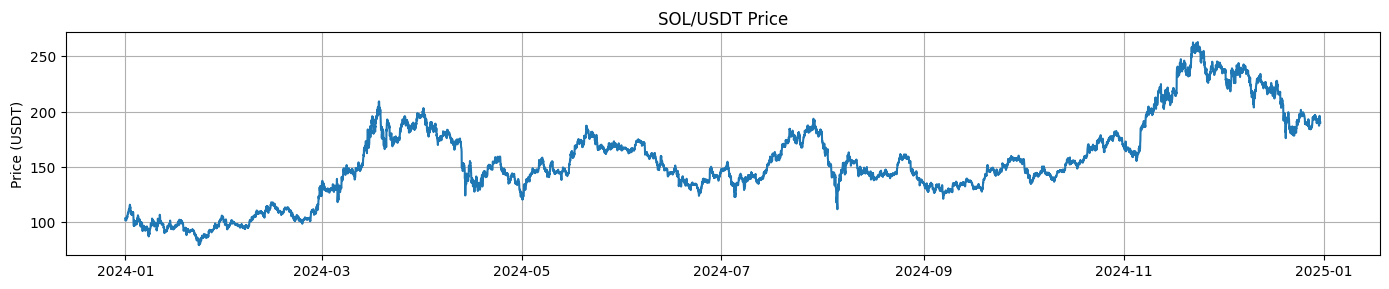

Scarico i dati per DOGE/USDT dal 2024-01-01 al 2024-12-31...


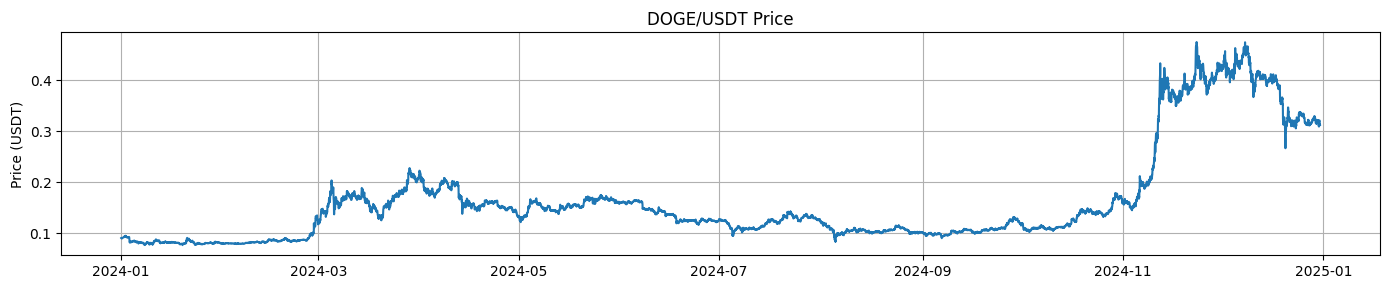

Scarico i dati per LINK/USDT dal 2024-01-01 al 2024-12-31...


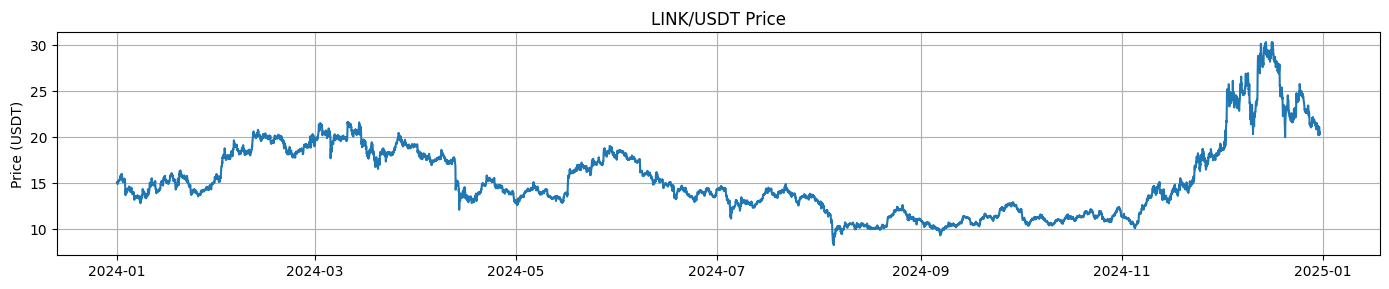

Scarico i dati per SIDUS/USDT dal 2024-01-01 al 2024-12-31...


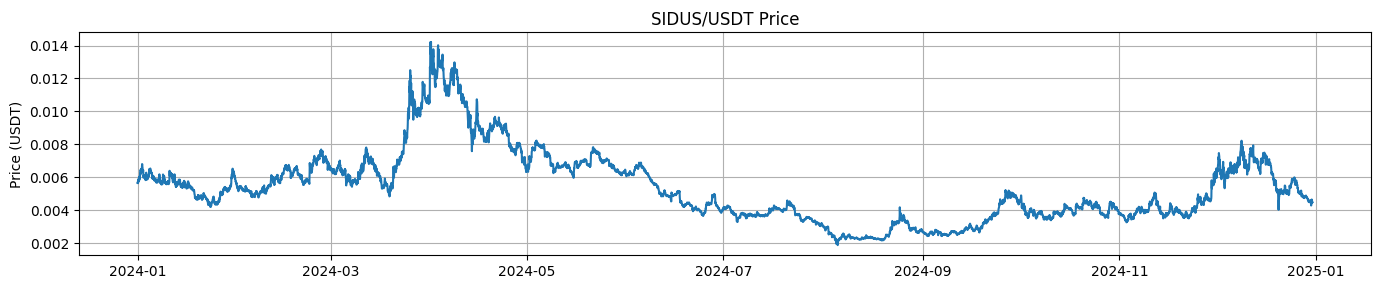

In [46]:
timeframe_download = '1h'  # Specifica il timeframe ('1m', '5m', '1h', '1d', etc.)
start_date = '2024-01-01'  # Data di inizio
end_date = '2024-12-31'  # Data di fine
plot = True
market = 'bybit'

data_frames = download_and_plot(cryptos, market, timeframe_download, start_date, end_date, plot)

In [47]:
crypto_prices = pd.DataFrame()
crypto_prices['timestamp'] = data_frames[cryptos[0]].index
for crypto in cryptos:
    crypto_prices[crypto] = data_frames[crypto]['close'].values
crypto_prices.set_index('timestamp', inplace=True)

# Calcolo del prezzo medio
crypto_prices['mean_price'] = crypto_prices.mean(axis=1)

crypto_prices

,SOL,DOGE,LINK,SIDUS,mean_price
timestamp,,,,,
2024-01-01 00:00:00,101.97,0.08985,15.1174,0.005650,29.295725
2024-01-01 01:00:00,104.11,0.09011,15.1697,0.005699,29.843877
2024-01-01 02:00:00,103.70,0.08979,15.0688,0.005682,29.716068
2024-01-01 03:00:00,103.08,0.08921,14.9246,0.005629,29.524860
2024-01-01 04:00:00,102.61,0.08910,14.9212,0.005691,29.406498
...,...,...,...,...,...
2024-12-30 20:00:00,194.87,0.32087,21.0921,0.004617,54.071897
2024-12-30 21:00:00,189.43,0.31098,20.4280,0.004470,52.543362
2024-12-30 22:00:00,191.17,0.31371,20.5641,0.004493,53.013076


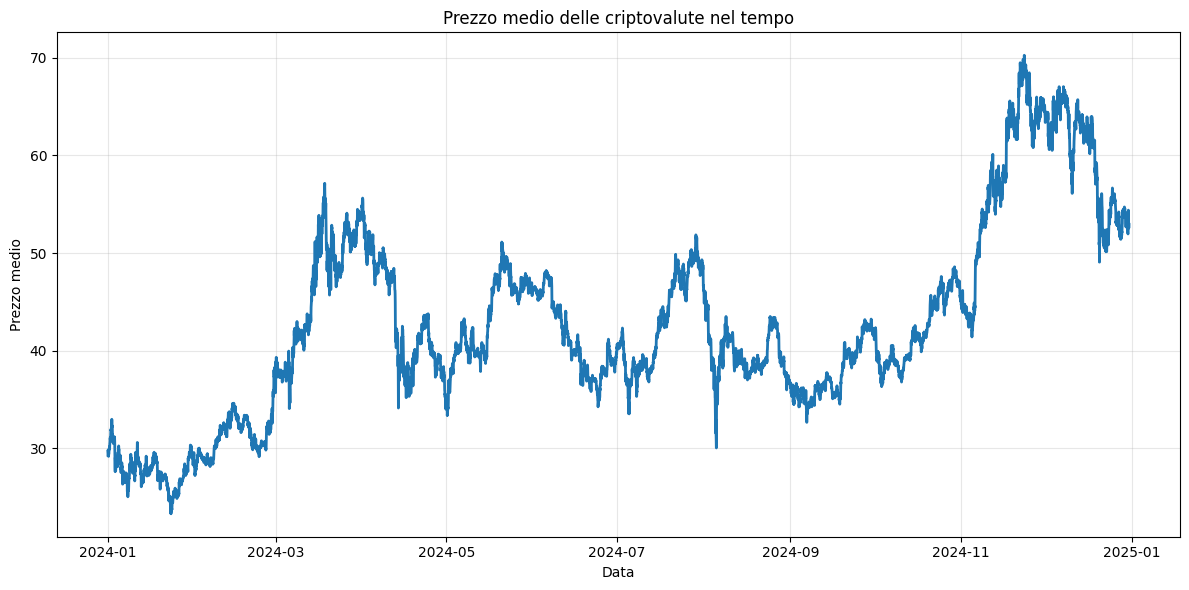

In [48]:
# Creazione del grafico
plt.figure(figsize=(12, 6))
plt.plot(crypto_prices.index, crypto_prices['mean_price'], label='Prezzo Medio', linewidth=2)

# Personalizzazione del grafico
plt.title('Prezzo medio delle criptovalute nel tempo')
plt.xlabel('Data')
plt.ylabel('Prezzo medio')
plt.grid(alpha=0.3)
plt.tight_layout()

# Mostra il grafico
plt.show()

In [49]:
# crypto_prices.to_csv(f'{list(crypto_prices.columns)}_USDT_timeframe_{timeframe_download}_start_date_{start_date}_end_date_{end_date}.csv')

In [50]:
# crypto_prices = pd.read_csv("['BTC', 'ETH', 'SOL', 'DOGE', 'LINK', 'AXS']_USDT_timeframe_1h_start_date_2021-01-01_end_date_2021-12-31.csv")
# crypto_prices['timestamp'] = pd.to_datetime(crypto_prices['timestamp'])
# crypto_prices.set_index('timestamp', inplace=True)
# crypto_prices

In [51]:
crypto_prices.isna().sum().sum()

0

In [67]:
df_results = simulate_trading_strategy(crypto_prices, 100, initial_allocations, rebalancing_period=24, ma_window=1, weighting_factor=1)
df_results

,timestamp,liquidity,portfolio_value,average_price,avg_price_return,MA_avg_price_return,price_SOL,qty_SOL,value_SOL,MA_SOL,...,qty_LINK,value_LINK,MA_LINK,LAST_LOCAL_MAX_LINK,price_SIDUS,qty_SIDUS,value_SIDUS,MA_SIDUS,LAST_LOCAL_MAX_SIDUS,portfolio_value_check
0,2024-01-01 00:00:00,0.000000,100.000000,29.295725,0.000000,0.000000,101.97,0.24517,25.000000,0.000000,...,1.653724,25.000000,0.000000,NaN,0.005650,4424.700448,25.000000,0.000000,NaN,100.000000
1,2024-01-01 01:00:00,0.000000,100.898095,29.843877,0.018711,0.018711,104.11,0.24517,25.524664,0.020987,...,1.653724,25.086490,0.003460,0.003460,0.005699,4424.700448,25.214598,0.008584,0.008584,100.898095
2,2024-01-01 02:00:00,0.000000,100.469112,29.716068,-0.004283,-0.004283,103.70,0.24517,25.424144,-0.003938,...,1.653724,24.919629,-0.006651,0.003460,0.005682,4424.700448,25.142033,-0.002878,0.008584,100.469112
3,2024-01-01 03:00:00,0.000000,99.681865,29.524860,-0.006435,-0.006435,103.08,0.24517,25.272139,-0.005979,...,1.653724,24.681162,-0.009569,0.003460,0.005629,4424.700448,24.906639,-0.009363,0.008584,99.681865
4,2024-01-01 04:00:00,0.000000,99.806507,29.406498,-0.004009,-0.004009,102.61,0.24517,25.156909,-0.004560,...,1.653724,24.675539,-0.000228,0.003460,0.005691,4424.700448,25.182740,0.011085,0.011085,99.806507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8756,2024-12-30 20:00:00,5.944657,304.832669,54.071897,-0.005966,-0.005966,194.87,0.00000,0.000000,-0.006678,...,14.170614,298.888012,0.000522,0.000522,0.004617,0.000000,0.000000,0.004241,0.004241,304.832669
8757,2024-12-30 21:00:00,5.944657,295.421964,52.543362,-0.028269,-0.028269,189.43,0.00000,0.000000,-0.027916,...,14.170614,289.477307,-0.031486,0.000522,0.004470,0.000000,0.000000,-0.032010,0.004241,295.421964
8758,2024-12-30 22:00:00,5.944657,297.350584,53.013076,0.008940,0.008940,191.17,0.00000,0.000000,0.009185,...,14.170614,291.405927,0.006662,0.006662,0.004493,0.000000,0.000000,0.005280,0.005280,297.350584
8759,2024-12-30 23:00:00,5.944657,297.452613,53.067432,0.001025,0.001025,191.38,0.00000,0.000000,0.001098,...,14.170614,291.507956,0.000350,0.006662,0.004477,0.000000,0.000000,-0.003583,0.005280,297.452613


In [68]:
df_results['portfolio_value'].iloc[-1] / df_results['portfolio_value'].iloc[0]

2.9430815352110526

In [69]:
df_results['portfolio_value'].max() / df_results['portfolio_value'].iloc[0]

5.213360797100251

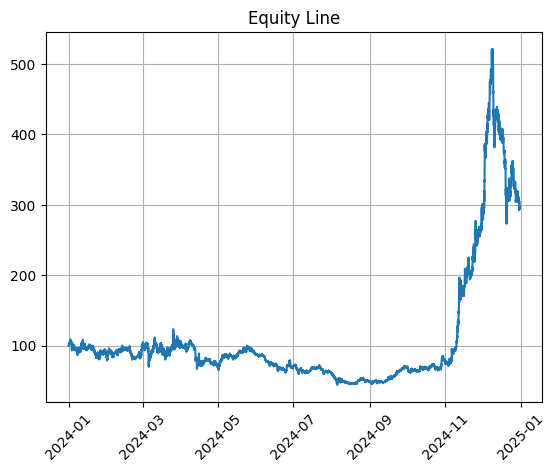

In [70]:
plt.title('Equity Line')
plt.xticks(rotation=45)
plt.grid()
plt.plot(df_results['timestamp'], df_results['portfolio_value']);

In [71]:
mdp.calcola_principali_metriche(prices=df_results['average_price'], bitcoin_posseduti=df_results['liquidity'], portfolio_values=df_results['portfolio_value'])

{'Total Return %': 194.30815352110528,
 'Max Drawdown': 64.00389912119478,
 'Volatility': 0.19168816165955707,
 'Sharpe Ratio': 0.25765599565323916,
 'Sortino Ratio': 0.4261601046484267,
 'Calmar Ratio': 3.035879941520008,
 'Profit Factor': 2.2440086494108704,
 'PnL': 1.272669594494045}